# Pairs Trading with ETFs
We will make use of Exchange Traded Funds (ETF) that track commodity prices and baskets of companies to implement pairs trading strategy. ETFs provide countless trade candidates. With loads of stock sectors, as well as bonds, oil, gold, silver, treasuries, international markets, and global and domestic indexes to choose from, ETF traders can find numerous opportunities while day trading or swing trading.

1. Competitive Pair
For example, the United States Oil Fund (USO A) and the Crude Oil Total Return Index (OIL B+) often move in lockstep as they both track the price of oil, but occasionally they diverge. Such divergences offer an opportunity to short the stronger fund and go long on the weaker one.
2. Sector Pairs
Certain sectors also share relationships with each other, although these are not always correlations. Rather, pair traders using sector ETFs rely more on each sector’s performance in a given economic climate.
3. Country Pairs
The stock markets of different countries are also tradable via ETF, providing many opportunities for pairs trading. ETFs such as the MSCI Japan Index (EWJ A), the MSCI Taiwan Index (EWT A-), the MSCI Malaysia Index (EWM B+) and the MSCI Singapore Index (EWS B+) are all suitable for creating pairs trades.
4. Index Pairs
There are many indexes that can be used to pairs trade as well. Indexes track commodity prices, bonds, small-cap and large-cap stock, as well as global markets. By watching indexes a trader can determine which asset classes have money flowing into and out of them.

To begin with, we will try to find co-integration between an equity and an ETF in the commodities market, say, oil price and the oil producing companies.

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import sqlite3 as db
import requests
import requests_cache
requests_cache.install_cache('cache')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.tsa.stattools as ts
import statsmodels.tools.tools as st
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from datetime import datetime
import time
from dateutil.relativedelta import relativedelta

Create ticker pairs

In [2]:
cnx = db.connect('/Users/Rachel/Dropbox/STA237 Project/tickers_database.db')
cur = cnx.cursor()

sql1 = 'SELECT Ticker FROM ETFtable WHERE Focus = "Crude Oil" AND "Asset Class" = "Commodities"'
cmd = pd.read_sql(sql1, con=cnx)['Ticker'].values.tolist()

sql2 = 'SELECT Ticker FROM ETFtable WHERE Focus = "Energy" AND "Asset Class" = "Equity"'
eqt = pd.read_sql(sql2, con=cnx)['Ticker'].values.tolist()

cnx.close()

In [3]:
ticker_pairs = []
for e in eqt:
    for c in cmd:
        pair = [e, c]
        ticker_pairs.append(pair)
    

There are 36*11=396 equity-commodity pairs

In [2]:
def pair_price_data(pair, start, end):
    """
    Return the price of a pair of assets.
    """
    asset1, asset2 = pair
    
    cnx = db.connect('/Users/Rachel/Dropbox/STA237 Project/tickers_database.db')
    cur = cnx.cursor()

    sql1 = 'SELECT Date, "Adj Close" FROM Pricetable WHERE Ticker = "' + asset1 + '" AND Date >= "' + start + '" AND Date <= "' + end + '"'
    df1 = pd.read_sql(sql1, con=cnx).set_index('Date')
    df1.columns = [asset1]
    
    sql2 = 'SELECT Date, "Adj Close" FROM Pricetable WHERE Ticker = "' + asset2 + '" AND Date >= "' + start + '" AND Date <= "' + end + '"'
    df2 = pd.read_sql(sql2, con=cnx).set_index('Date')
    df2.columns = [asset2]
    
    df = pd.concat([df1, df2], axis = 1, join = 'inner')
    
    return df

## STEP 1 Co-integration Test

### 1. Check stationary for each time series by Augmented Dickey-Fuller test
Null Hypothesis: the time series has a unit root, meaning it is non-stationary. It has some time dependent structure

In [5]:
def ADF(series, threshold, print_conclusion = False):
    adf = ts.adfuller(series)

    if print_conclusion:
        print('Augmented Dickey Fuller test statistic =', adf[0])
        print('Augmented Dickey Fuller p-value =', adf[1])
            
        if adf[1] > threshold:
            print('The time series is non-stationary.')
        else:
            print('the time series is stationary.')
    
    return adf[1]


### 2. Check first ordr integration, I(1), for each time series by ADF test

In [6]:
def I_1_test(ts, threshold, print_conclusion = False):
    # H_0: The difference of time series has a unit root and is non-stationary.
    p_t = ts.iloc[1:,]
    p_p = ts.shift(1).iloc[1:]
    p_d = p_t - p_p
    pvalue = ADF(p_d, threshold)
    
    if print_conclusion:
        if pvalue < threshold:
            print('The p-value = %f. The time series is I(1)' % pvalue)
        else:
            print('The p-value = %f. The time series is not I(1)' % pvalue)
    return pvalue

### 3. Run OLS on the two pricese series and find  the optimal hedge ratio (cointegration coefficient) of the two assets

For asset Y and asset X, we fit an OLS regression on their prices
$$Y_t=\beta X_t+\epsilon_t$$
where $\beta$ is the parameter we are about to estimate and the hedge ratio in the trading strategy. And the residual $$\epsilon_t = Y_t-\beta X_t$$
is the spread of the pair that we will trade on and should have stationary if the pair of assets are co-integrated.

In [6]:
def regression(y, x):
    regr = OLS(y, x).fit()
    print('The hedge ratio is %f.' % regr.params.item())
    spread = regr.resid
    return regr.params.item(), spread

### 3. Check stationary of the residuals

Null hypothesis: the spread time series is non-stationary. It is therefore not mean reverting and the two prices series are not co-integrated.

### 4. Rolling ADF method
(1) Select optimal window size, eg. 30%, 40%, 50% of the whole sample.

(2) Run Rolling ADF test with optimal window

In [20]:
def rolling(ts, window_size, threshold = None, select_optimal_size = False):    
    n = len(ts)
    m = int(np.floor(window_size * n))
    adfs = pd.DataFrame([ADF(ts[i:(m+i)], .05) for i in range(n-m)], columns = ['ADF_pvalue'])
    
    if select_optimal_size:      
        max_pvalue = adfs.max().item()
        return max_pvalue
    else:
        pass_ratio = (adfs['ADF_pvalue'] < threshold).sum().item()/(n-m)
        return pass_ratio
    
def select_window_size(ts):
    
    if type(ts) != np.ndarray:
        ts = np.array(ts)

    window_sizes = [.4, .5, .6, .7, .8]
    pvs = [[w_s, rolling(ts, w_s, select_optimal_size = True)] for w_s in window_sizes]
    df = pd.DataFrame(pvs, columns = ['window_size', 'max_p_value']).set_index('window_size')
    # optimal window size
    opt_m = df.idxmax().item()
    print('The optimal window size is %f' % opt_m)
    return opt_m
    
def Rolling_ADF(ts, window_size, threshold):
    if type(ts) != np.ndarray:
        ts = np.array(ts)
            
    # rolling ADF test with optimal window size
    r = rolling(ts, window_size, threshold = threshold)
    print('The ratio of successful ADF tests is %f' % r)  
    return r

In [10]:
def optimal_window_size(pair, start, end):
    print(pair)
    # get price series
    asset1, asset2 = pair
    p = pair_price_data(pair, start, end).dropna()
    log_p = np.log(p)
    
    if len(p) > 50:
        # run OLS regression on two prices series and get spread
        h_r, spread = regression(p[asset1], p[asset2])
        # check stationary of the spread
        w_s = select_window_size(spread)       
        return w_s
    else:
        print('Not Found Data')

start_date, end_date = '2015-11-25', '2016-11-25'        
result = [optimal_window_size(t_p, start_date, end_date) for t_p in ticker_pairs]
sizes = [p for p in result if p is not None]

['AMLP', 'USO']
The hedge ratio is 0.983371.
The optimal window size is 0.400000
['AMLP', 'OIL']
The hedge ratio is 1.802450.
The optimal window size is 0.400000
['AMLP', 'UCO']
The hedge ratio is 0.965011.
The optimal window size is 0.400000
['AMLP', 'DBO']
The hedge ratio is 1.225135.
The optimal window size is 0.400000
['AMLP', 'SCO']
The hedge ratio is 0.081859.
The optimal window size is 0.400000
['AMLP', 'DWT']
Not Found Data
['AMLP', 'UWT']
Not Found Data
['AMLP', 'BNO']
The hedge ratio is 0.779490.
The optimal window size is 0.500000
['AMLP', 'USL']
The hedge ratio is 0.593537.
The optimal window size is 0.400000
['AMLP', 'OILB']
Not Found Data
['AMLP', 'OIIL']
The hedge ratio is 0.348445.
The optimal window size is 0.500000
['AMJ', 'USO']
The hedge ratio is 2.512792.
The optimal window size is 0.400000
['AMJ', 'OIL']
The hedge ratio is 4.605868.
The optimal window size is 0.400000
['AMJ', 'UCO']
The hedge ratio is 2.465901.
The optimal window size is 0.400000
['AMJ', 'DBO']
Th

The optimal window size is 0.400000
['IMLP', 'OIL']
The hedge ratio is 2.916331.
The optimal window size is 0.400000
['IMLP', 'UCO']
The hedge ratio is 1.561627.
The optimal window size is 0.400000
['IMLP', 'DBO']
The hedge ratio is 1.982694.
The optimal window size is 0.600000
['IMLP', 'SCO']
The hedge ratio is 0.132173.
The optimal window size is 0.500000
['IMLP', 'DWT']
Not Found Data
['IMLP', 'UWT']
Not Found Data
['IMLP', 'BNO']
The hedge ratio is 1.261471.
The optimal window size is 0.400000
['IMLP', 'USL']
The hedge ratio is 0.960457.
The optimal window size is 0.400000
['IMLP', 'OILB']
Not Found Data
['IMLP', 'OIIL']
The hedge ratio is 0.563554.
The optimal window size is 0.400000
['MLPO', 'USO']
The hedge ratio is 1.272324.
The optimal window size is 0.400000
['MLPO', 'OIL']
The hedge ratio is 2.335871.
The optimal window size is 0.400000
['MLPO', 'UCO']
The hedge ratio is 1.252424.
The optimal window size is 0.400000
['MLPO', 'DBO']
The hedge ratio is 1.586320.
The optimal wi

The optimal window size is 0.500000
['IEO', 'USL']
The hedge ratio is 3.098922.
The optimal window size is 0.400000
['IEO', 'OILB']
Not Found Data
['IEO', 'OIIL']
The hedge ratio is 1.796578.
The optimal window size is 0.400000
['XES', 'USO']
The hedge ratio is 1.635822.
The optimal window size is 0.400000
['XES', 'OIL']
The hedge ratio is 3.002554.
The optimal window size is 0.400000
['XES', 'UCO']
The hedge ratio is 1.612138.
The optimal window size is 0.400000
['XES', 'DBO']
The hedge ratio is 2.037523.
The optimal window size is 0.400000
['XES', 'SCO']
The hedge ratio is 0.137140.
The optimal window size is 0.400000
['XES', 'DWT']
Not Found Data
['XES', 'UWT']
Not Found Data
['XES', 'BNO']
The hedge ratio is 1.293189.
The optimal window size is 0.400000
['XES', 'USL']
The hedge ratio is 0.985437.
The optimal window size is 0.400000
['XES', 'OILB']
Not Found Data
['XES', 'OIIL']
The hedge ratio is 0.569367.
The optimal window size is 0.400000
['IEZ', 'USO']
The hedge ratio is 3.3530

The optimal window size is 0.400000
['ERX', 'USO']
The hedge ratio is 2.587701.
The optimal window size is 0.400000
['ERX', 'OIL']
The hedge ratio is 4.741001.
The optimal window size is 0.400000
['ERX', 'UCO']
The hedge ratio is 2.548321.
The optimal window size is 0.400000
['ERX', 'DBO']
The hedge ratio is 3.222780.
The optimal window size is 0.400000
['ERX', 'SCO']
The hedge ratio is 0.208811.
The optimal window size is 0.400000
['ERX', 'DWT']
Not Found Data
['ERX', 'UWT']
Not Found Data
['ERX', 'BNO']
The hedge ratio is 2.055556.
The optimal window size is 0.400000
['ERX', 'USL']
The hedge ratio is 1.562142.
The optimal window size is 0.700000
['ERX', 'OILB']
Not Found Data
['ERX', 'OIIL']
The hedge ratio is 0.927554.
The optimal window size is 0.400000
['RYE', 'USO']
The hedge ratio is 4.820766.
The optimal window size is 0.400000
['RYE', 'OIL']
The hedge ratio is 8.836458.
The optimal window size is 0.400000
['RYE', 'UCO']
The hedge ratio is 4.729952.
The optimal window size is 0

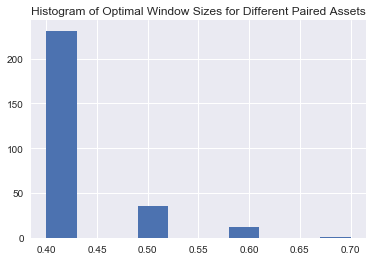

In [11]:
plt.hist(sizes)
plt.title('Histogram of Optimal Window Sizes for Different Paired Assets')
plt.savefig('Hist of Optimal Window Size')

We decided to use 40% as the optimal window size in Rolling ADF test.

### 5. Recursive ADF Method

In [9]:
def Recursive_ADF(ts, threshold):
    if type(ts) != np.ndarray:
        ts = np.array(ts)
    
    n = len(ts)
    m0 = int(np.floor(.3 * n))
    df = pd.DataFrame([ADF(ts[:m0+i], .05) for i in range(n-m0)], columns = ['p_value'])
    r = (df['p_value'] < threshold).sum().item()/(n-m0)   
    print('The ratio is %f' % r)
    return r

### A complete Engle-Granger two-step method for co-integration

In [10]:
def CIG(pair, start, end, method, threshold, window_size = None):
    """
    Run Co-integratio test for a pair of assets.
    Input:
        pair: list of names of paired assets, eg ['AMLP', 'USO']
        start, end: test start date and end date, eg '2015-11-25'
        method: 'adf', 'rolling adf' or 'recursive adf'
        threshold: critical value to reject null hypothesis
        window_size: window size used for rolling adf test
        
    """
    print(pair)
    # get price series
    asset1, asset2 = pair
    p = pair_price_data(pair, start, end).dropna()
    log_p = np.log(p)
    
    if len(p) > 50:
        # check stationary for each series
        s_1 = ADF(p[asset1], threshold, print_conclusion = True)
        s_2 = ADF(p[asset2], threshold, print_conclusion = True)
        # check integration of order1, I(1) for each series
        I_1 = I_1_test(p[asset1], threshold, print_conclusion = True)
        I_2 = I_1_test(p[asset2], threshold, print_conclusion = True)
        
        if s_1 > threshold and s_2 > threshold and I_1 < threshold and I_2 < threshold:
            # run OLS regression on two prices series and get spread
            h_r, spread = regression(p[asset1], p[asset2])        
            # check stationary of spread
            
            if method == 'adf':
                p_v = ADF(spread, threshold, False)
                if p_v > threshold:
                    print('The two series, %s and %s, are not co-integrated by ADF test.' % (asset1, asset2))
                else:
                    print('The two series, %s and %s, are co-integrated by ADF test.' % (asset1, asset2))
                    return asset1, asset2, p_v
                    
            if method == 'rolling adf':
                r = Rolling_ADF(spread, window_size, threshold = threshold) 
                return asset1, asset2, r

            if method == 'recursive adf':
                r = Recursive_ADF(spread, threshold)
                return asset1, asset2, r
            
        else:
            print('The two series, %s and %s, do not satisfy the prerequisite of co-integration' % (asset1, asset2))
    else:
        print('Not Found Data')


In [32]:
start_date, end_date = '2016-05-25', '2017-10-25'
result = [CIG(t_p, start_date, end_date, 'adf', threshold = .05) for t_p in ticker_pairs]
df1 = pd.DataFrame([t for t in result if t is not None ], columns = ['Asset1', 'Asset2', 'P-value'])
df1.to_excel('Cointegrated Pairs by ADF.xlsx')

['AMLP', 'USO']
Augmented Dickey Fuller test statistic = -1.41051676008
Augmented Dickey Fuller p-value = 0.577223995781
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.83646658299
Augmented Dickey Fuller p-value = 0.0532506168822
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.080314.
The two series, AMLP and USO, are not co-integrated by ADF test.
['AMLP', 'OIL']
Augmented Dickey Fuller test statistic = -1.40844784465
Augmented Dickey Fuller p-value = 0.578219481563
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.039674.
The two series, AMLP and OIL, are not co-integrated by ADF test.
['AMLP', 'UCO']
Augmented D

Augmented Dickey Fuller test statistic = -0.627705664124
Augmented Dickey Fuller p-value = 0.864597995243
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000001. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.529492.
The two series, AMJ and UWT, are not co-integrated by ADF test.
['AMJ', 'BNO']
Augmented Dickey Fuller test statistic = -1.66238492216
Augmented Dickey Fuller p-value = 0.45058959952
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.050562.
The two series, AMJ and BNO, are not co-integrated by ADF test.
['AMJ', 'USL']
Augmented Dickey Fuller test stat

Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.673596.
The two series, MLPI and UCO, are not co-integrated by ADF test.
['MLPI', 'DBO']
Augmented Dickey Fuller test statistic = -1.45495653889
Augmented Dickey Fuller p-value = 0.555664506013
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.974613.
The two series, MLPI and DBO, are not co-integrated by ADF test.
['MLPI', 'SCO']
Augmented Dickey Fuller test statistic = -1.45495653889
Augmented Dickey Fuller p-value = 0.555664506013
The time series is non-stationary.
Augmented Dickey Fuller test

The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, MLPA and OIIL, do not satisfy the prerequisite of co-integration
['AMZA', 'USO']
Augmented Dickey Fuller test statistic = -2.46799301634
Augmented Dickey Fuller p-value = 0.123457432293
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.83646658299
Augmented Dickey Fuller p-value = 0.0532506168822
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.843934.
The two series, AMZA and USO, are not co-integrated by ADF test.
['AMZA', 'OIL']
Augmented Dickey Fuller test statistic = -2.46398088703
Augmented Dickey Fuller p-value = 0.1244858901
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is

The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.780542.
The two series, ATMP and DWT, are not co-integrated by ADF test.
['ATMP', 'UWT']
Augmented Dickey Fuller test statistic = -0.52331043984
Augmented Dickey Fuller p-value = 0.887386790249
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.144259.
The two series, ATMP and UWT, are not co-integrated by ADF test.
['ATMP', 'BNO']
Augmented Dickey Fuller test statistic = -2.62433726335
Augmented Dickey Fuller p-value = 0.0880708441394
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The 

The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, MLPX and USO, do not satisfy the prerequisite of co-integration
['MLPX', 'OIL']
Augmented Dickey Fuller test statistic = -3.04532633066
Augmented Dickey Fuller p-value = 0.0308728735312
the time series is stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, MLPX and OIL, do not satisfy the prerequisite of co-integration
['MLPX', 'UCO']
Augmented Dickey Fuller test statistic = -3.03901652283
Augmented Dickey Fuller p-value = 0.0314079310679
the time series is stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 

Augmented Dickey Fuller test statistic = -2.02202349082
Augmented Dickey Fuller p-value = 0.277000825526
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.106243.
The two series, MLPC and BNO, are not co-integrated by ADF test.
['MLPC', 'USL']
Augmented Dickey Fuller test statistic = -2.02202349082
Augmented Dickey Fuller p-value = 0.277000825526
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.67636731678
Augmented Dickey Fuller p-value = 0.0782177919559
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.864078.
The two series, MLPC and USL, are not co-integrated by ADF test.
['MLPC', 'OILB']
Augmented Dickey Fuller tes

Augmented Dickey Fuller test statistic = -2.15293189198
Augmented Dickey Fuller p-value = 0.223769521996
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.169522.
The two series, IMLP and DBO, are not co-integrated by ADF test.
['IMLP', 'SCO']
Augmented Dickey Fuller test statistic = -2.15293189198
Augmented Dickey Fuller p-value = 0.223769521996
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.274155.
The two series, IMLP and SCO, are not co-integrated by ADF test.
['IMLP', 'DWT']
Augmented Dickey Fuller test

Augmented Dickey Fuller test statistic = -2.86575850222
Augmented Dickey Fuller p-value = 0.0494771702348
the time series is stationary.
Augmented Dickey Fuller test statistic = -2.83646658299
Augmented Dickey Fuller p-value = 0.0532506168822
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, YMLP and USO, do not satisfy the prerequisite of co-integration
['YMLP', 'OIL']
Augmented Dickey Fuller test statistic = -2.87474469968
Augmented Dickey Fuller p-value = 0.0483646536445
the time series is stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, YMLP and OIL, do not satisfy the prerequisite of co-integration
['YMLP', 'UCO']
Augmented Dickey Fuller test statistic = -2.86575850222
Augme

Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.191015.
The two series, ZMLP and BNO, are not co-integrated by ADF test.
['ZMLP', 'USL']
Augmented Dickey Fuller test statistic = -2.23941663953
Augmented Dickey Fuller p-value = 0.192251666556
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.67636731678
Augmented Dickey Fuller p-value = 0.0782177919559
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.930689.
The two series, ZMLP and USL, are co-integrated by ADF test.
['ZMLP', 'OILB']
Augmented Dickey Fuller test statistic = -0.986492938112
Augmented Dickey Fuller p-value = 0.758158758017
The time series is non-stationary.
Augmented Dickey Fuller test s

Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.463020.
The two series, MLPY and UCO, are not co-integrated by ADF test.
['MLPY', 'DBO']
Augmented Dickey Fuller test statistic = -2.54943910817
Augmented Dickey Fuller p-value = 0.103903792852
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.823971.
The two series, MLPY and DBO, are not co-integrated by ADF test.
['MLPY', 'SCO']
Augmented Dickey Fuller test statistic = -2.54943910817
Augmented Dickey Fuller p-value = 0.103903792852
The time series is non-stationary.
Augmented Dickey Fuller test

Augmented Dickey Fuller test statistic = -1.33868661478
Augmented Dickey Fuller p-value = 0.611292633879
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.14203457227
Augmented Dickey Fuller p-value = 0.227951487097
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.642372.
The two series, BMLP and OIIL, are not co-integrated by ADF test.
['ENFR', 'USO']
Augmented Dickey Fuller test statistic = -2.77312801245
Augmented Dickey Fuller p-value = 0.0622159454383
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.83646658299
Augmented Dickey Fuller p-value = 0.0532506168822
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.106107.
The two series, ENFR and USO, are not co-integrated by ADF test.
['ENFR', 'OIL']
Augmented Dickey Fuller t

Augmented Dickey Fuller test statistic = -0.307699185593
Augmented Dickey Fuller p-value = 0.924406796703
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.352969.
The two series, MLPQ and UWT, are not co-integrated by ADF test.
['MLPQ', 'BNO']
Augmented Dickey Fuller test statistic = -1.43330604436
Augmented Dickey Fuller p-value = 0.566208778041
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.102547.
The two series, MLPQ and BNO, are not co-integrated by ADF test.
['MLPQ', 'USL']
Augmented Dickey Fuller test

Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.816749.
The two series, OIH and UCO, are not co-integrated by ADF test.
['OIH', 'DBO']
Augmented Dickey Fuller test statistic = -1.06668233152
Augmented Dickey Fuller p-value = 0.728174134828
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.252553.
The two series, OIH and DBO, are not co-integrated by ADF test.
['OIH', 'SCO']
Augmented Dickey Fuller test statistic = -1.06668233152
Augmented Dickey Fuller p-value = 0.728174134828
The time series is non-stationary.
Augmented Dickey Fuller test sta

The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.150787.
The two series, IEO and OILB, are co-integrated by ADF test.
['IEO', 'OIIL']
Augmented Dickey Fuller test statistic = -1.99701818243
Augmented Dickey Fuller p-value = 0.287882050826
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, IEO and OIIL, do not satisfy the prerequisite of co-integration
['XES', 'USO']
Augmented Dickey Fuller test statistic = -1.16452468294
Augmented Dickey Fuller p-value = 0.688667184987
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.83646658299
Augmented Dickey Fuller p-value = 0.0532506168822
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
T

The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.546700.
The two series, IEZ and SCO, are not co-integrated by ADF test.
['IEZ', 'DWT']
Augmented Dickey Fuller test statistic = -1.20644133352
Augmented Dickey Fuller p-value = 0.670818692938
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.97123192703
Augmented Dickey Fuller p-value = 0.299327566664
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.293209.
The two series, IEZ and DWT, are not co-integrated by ADF test.
['IEZ', 'UWT']
Augmented Dickey Fuller test statistic = -1.20644133352
Augmented Dickey Fuller p-value = 0.670818692938
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time

The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.625584.
The two series, PXE and OIL, are co-integrated by ADF test.
['PXE', 'UCO']
Augmented Dickey Fuller test statistic = -1.91715924947
Augmented Dickey Fuller p-value = 0.324032412126
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.301987.
The two series, PXE and UCO, are not co-integrated by ADF test.
['PXE', 'DBO']
Augmented Dickey Fuller test statistic = -1.91715924947
Augmented Dickey Fuller p-value = 0.324032412126
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time ser

The two series, DRIP and BNO, are not co-integrated by ADF test.
['DRIP', 'USL']
Augmented Dickey Fuller test statistic = -2.34885683026
Augmented Dickey Fuller p-value = 0.156694234188
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.67636731678
Augmented Dickey Fuller p-value = 0.0782177919559
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.169012.
The two series, DRIP and USL, are not co-integrated by ADF test.
['DRIP', 'OILB']
Augmented Dickey Fuller test statistic = -1.79920011378
Augmented Dickey Fuller p-value = 0.380858887171
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.360609.
The two series, DRIP and O

Augmented Dickey Fuller test statistic = -2.13207047597
Augmented Dickey Fuller p-value = 0.231815921444
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 7.704848.
The two series, XLE and DBO, are co-integrated by ADF test.
['XLE', 'SCO']
Augmented Dickey Fuller test statistic = -2.13207047597
Augmented Dickey Fuller p-value = 0.231815921444
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.978691.
The two series, XLE and SCO, are not co-integrated by ADF test.
['XLE', 'DWT']
Augmented Dickey Fuller test statist

The two series, VDE and OILB, are co-integrated by ADF test.
['VDE', 'OIIL']
Augmented Dickey Fuller test statistic = -2.01440914764
Augmented Dickey Fuller p-value = 0.280291146118
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, VDE and OIIL, do not satisfy the prerequisite of co-integration
['IYE', 'USO']
Augmented Dickey Fuller test statistic = -2.05083926692
Augmented Dickey Fuller p-value = 0.264735950794
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.83646658299
Augmented Dickey Fuller p-value = 0.0532506168822
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.501223.
The two series, IYE and USO, are co-integrated by

Augmented Dickey Fuller test statistic = -1.87391615392
Augmented Dickey Fuller p-value = 0.344429487679
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.673894.
The two series, IXC and UWT, are not co-integrated by ADF test.
['IXC', 'BNO']
Augmented Dickey Fuller test statistic = -2.64404121348
Augmented Dickey Fuller p-value = 0.0842321067843
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.240653.
The two series, IXC and BNO, are co-integrated by ADF test.
['IXC', 'USL']
Augmented Dickey Fuller test statist

Augmented Dickey Fuller test statistic = -1.82704128298
Augmented Dickey Fuller p-value = 0.367121474773
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 5.498425.
The two series, ERX and OIL, are not co-integrated by ADF test.
['ERX', 'UCO']
Augmented Dickey Fuller test statistic = -1.82012835289
Augmented Dickey Fuller p-value = 0.370515301869
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.958178.
The two series, ERX and UCO, are not co-integrated by ADF test.
['ERX', 'DBO']
Augmented Dickey Fuller test sta

Augmented Dickey Fuller test statistic = -1.20564687686
Augmented Dickey Fuller p-value = 0.671161862938
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.097388.
The two series, RYE and OILB, are co-integrated by ADF test.
['RYE', 'OIIL']
Augmented Dickey Fuller test statistic = -1.79691769896
Augmented Dickey Fuller p-value = 0.381993040761
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, RYE and OIIL, do not satisfy the prerequisite of co-integration


In [21]:
result2 = [CIG(t_p, start_date, end_date, 'rolling adf', threshold = .05, window_size = .7) for t_p in ticker_pairs]
df2 = pd.DataFrame([t for t in result2 if t is not None ], columns = ['Asset1', 'Asset2', 'Ratio']).sort_values('Ratio', ascending = False).reset_index(drop = True)
df2.to_excel('Cointegrated Pairs by Rolling ADF.xlsx')

['AMLP', 'USO']
Augmented Dickey Fuller test statistic = -1.41051676008
Augmented Dickey Fuller p-value = 0.577223995781
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.83646658299
Augmented Dickey Fuller p-value = 0.0532506168822
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.080314.
The ratio of successful ADF tests is 0.055556
['AMLP', 'OIL']
Augmented Dickey Fuller test statistic = -1.40844784465
Augmented Dickey Fuller p-value = 0.578219481563
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.039674.
The ratio of successful ADF tests is 0.000000
['AMLP', 'UCO']
Augmented Dickey Fuller test statistic = -1.41051

The ratio of successful ADF tests is 0.104478
['AMJ', 'BNO']
Augmented Dickey Fuller test statistic = -1.66238492216
Augmented Dickey Fuller p-value = 0.45058959952
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.050562.
The ratio of successful ADF tests is 0.083333
['AMJ', 'USL']
Augmented Dickey Fuller test statistic = -1.66238492216
Augmented Dickey Fuller p-value = 0.45058959952
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.67636731678
Augmented Dickey Fuller p-value = 0.0782177919559
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.602387.
The ratio of successful ADF tests is 0.000000
['AMJ', 'OILB']
Augmente

The ratio of successful ADF tests is 0.000000
['MLPI', 'DBO']
Augmented Dickey Fuller test statistic = -1.45495653889
Augmented Dickey Fuller p-value = 0.555664506013
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.974613.
The ratio of successful ADF tests is 0.000000
['MLPI', 'SCO']
Augmented Dickey Fuller test statistic = -1.45495653889
Augmented Dickey Fuller p-value = 0.555664506013
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.376643.
The ratio of successful ADF tests is 0.000000
['MLPI', 'DWT']
Augm

The ratio of successful ADF tests is 0.000000
['MLPA', 'OIIL']
Augmented Dickey Fuller test statistic = -1.4972867752
Augmented Dickey Fuller p-value = 0.534853102887
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, MLPA and OIIL, do not satisfy the prerequisite of co-integration
['AMZA', 'USO']
Augmented Dickey Fuller test statistic = -2.46799301634
Augmented Dickey Fuller p-value = 0.123457432293
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.83646658299
Augmented Dickey Fuller p-value = 0.0532506168822
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.843934.
The ratio of successful ADF tests is 0.009259
['AMZA', 'OIL']


The ratio of successful ADF tests is 0.000000
['ATMP', 'UWT']
Augmented Dickey Fuller test statistic = -0.52331043984
Augmented Dickey Fuller p-value = 0.887386790249
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.144259.
The ratio of successful ADF tests is 0.119403
['ATMP', 'BNO']
Augmented Dickey Fuller test statistic = -2.62433726335
Augmented Dickey Fuller p-value = 0.0880708441394
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.524082.
The ratio of successful ADF tests is 0.129630
['ATMP', 'USL']
Augm

The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, MLPX and DBO, do not satisfy the prerequisite of co-integration
['MLPX', 'SCO']
Augmented Dickey Fuller test statistic = -3.03901652283
Augmented Dickey Fuller p-value = 0.0314079310679
the time series is stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, MLPX and SCO, do not satisfy the prerequisite of co-integration
['MLPX', 'DWT']
Augmented Dickey Fuller test statistic = -1.33146608573
Augmented Dickey Fuller p-value = 0.614656453029
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.97123192703
Augmented Dickey Fuller p-value = 0.299327566664
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value

The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, TPYP and OIL, do not satisfy the prerequisite of co-integration
['TPYP', 'UCO']
Augmented Dickey Fuller test statistic = -3.01964685822
Augmented Dickey Fuller p-value = 0.0330999223474
the time series is stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, TPYP and UCO, do not satisfy the prerequisite of co-integration
['TPYP', 'DBO']
Augmented Dickey Fuller test statistic = -3.01964685822
Augmented Dickey Fuller p-value = 0.0330999223474
the time series is stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 

The ratio of successful ADF tests is 0.000000
['IMLP', 'OILB']
Augmented Dickey Fuller test statistic = -0.90587181747
Augmented Dickey Fuller p-value = 0.786032593995
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.375485.
The ratio of successful ADF tests is 0.197183
['IMLP', 'OIIL']
Augmented Dickey Fuller test statistic = -2.15293189198
Augmented Dickey Fuller p-value = 0.223769521996
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, IMLP and OIIL, do not satisfy the prerequisite of co-integration
['MLPO', 'USO']

The ratio of successful ADF tests is 0.000000
['YMLP', 'UWT']
Augmented Dickey Fuller test statistic = -1.53073019395
Augmented Dickey Fuller p-value = 0.518258507411
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.223529.
The ratio of successful ADF tests is 0.104478
['YMLP', 'BNO']
Augmented Dickey Fuller test statistic = -2.86575850222
Augmented Dickey Fuller p-value = 0.0494771702348
the time series is stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, YMLP and BNO, do not satisfy the prerequisite of co-integration
['YMLP', 'USL']
Aug

The ratio of successful ADF tests is 0.000000
['MLPZ', 'UCO']
Augmented Dickey Fuller test statistic = -1.85412069729
Augmented Dickey Fuller p-value = 0.353942177228
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.063980.
The ratio of successful ADF tests is 0.000000
['MLPZ', 'DBO']
Augmented Dickey Fuller test statistic = -1.85412069729
Augmented Dickey Fuller p-value = 0.353942177228
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 5.417756.
The ratio of successful ADF tests is 0.000000
['MLPZ', 'SCO']
Augm

The ratio of successful ADF tests is 0.037037
['MLPY', 'OILB']
Augmented Dickey Fuller test statistic = -1.18799081226
Augmented Dickey Fuller p-value = 0.678740309241
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.142029.
The ratio of successful ADF tests is 0.591549
['MLPY', 'OIIL']
Augmented Dickey Fuller test statistic = -2.54943910817
Augmented Dickey Fuller p-value = 0.103903792852
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, MLPY and OIIL, do not satisfy the prerequisite of co-integration
['BMLP', 'USO']

The ratio of successful ADF tests is 0.000000
['ENFR', 'DWT']
Augmented Dickey Fuller test statistic = -2.34291031637
Augmented Dickey Fuller p-value = 0.158501638514
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.97123192703
Augmented Dickey Fuller p-value = 0.299327566664
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.811775.
The ratio of successful ADF tests is 0.000000
['ENFR', 'UWT']
Augmented Dickey Fuller test statistic = -2.34291031637
Augmented Dickey Fuller p-value = 0.158501638514
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.185637.
The ratio of successful ADF tests is 0.104478
['ENFR', 'BNO']
Augm

The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.357484.
The ratio of successful ADF tests is 0.250000
['XOP', 'OIL']
Augmented Dickey Fuller test statistic = -1.42452499123
Augmented Dickey Fuller p-value = 0.570463705476
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 6.348387.
The ratio of successful ADF tests is 0.425926
['XOP', 'UCO']
Augmented Dickey Fuller test statistic = -1.43018574892
Augmented Dickey Fuller p-value = 0.567722223223
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.0000

The ratio of successful ADF tests is 0.000000
['OIH', 'USL']
Augmented Dickey Fuller test statistic = -1.06668233152
Augmented Dickey Fuller p-value = 0.728174134828
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.67636731678
Augmented Dickey Fuller p-value = 0.0782177919559
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.548691.
The ratio of successful ADF tests is 0.000000
['OIH', 'OILB']
Augmented Dickey Fuller test statistic = -0.526328350808
Augmented Dickey Fuller p-value = 0.886775489688
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.556566.
The ratio of successful ADF tests is 0.000000
['OIH', 'OIIL']
Aug

The ratio of successful ADF tests is 0.000000
['XES', 'SCO']
Augmented Dickey Fuller test statistic = -1.16452468294
Augmented Dickey Fuller p-value = 0.688667184987
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.263743.
The ratio of successful ADF tests is 0.000000
['XES', 'DWT']
Augmented Dickey Fuller test statistic = -1.30472896491
Augmented Dickey Fuller p-value = 0.627006038864
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.97123192703
Augmented Dickey Fuller p-value = 0.299327566664
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.615454.
The ratio of successful ADF tests is 0.000000
['XES', 'UWT']
Augment

The ratio of successful ADF tests is 0.000000
['GUSH', 'OIL']
Augmented Dickey Fuller test statistic = -0.932337772308
Augmented Dickey Fuller p-value = 0.777136713731
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 10.494919.
The ratio of successful ADF tests is 0.000000
['GUSH', 'UCO']
Augmented Dickey Fuller test statistic = -0.931869231033
Augmented Dickey Fuller p-value = 0.777296371206
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.548218.
The ratio of successful ADF tests is 0.000000
['GUSH', 'DBO']
A

The ratio of successful ADF tests is 0.185185
['PXE', 'USL']
Augmented Dickey Fuller test statistic = -1.91715924947
Augmented Dickey Fuller p-value = 0.324032412126
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.67636731678
Augmented Dickey Fuller p-value = 0.0782177919559
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.110096.
The ratio of successful ADF tests is 0.379630
['PXE', 'OILB']
Augmented Dickey Fuller test statistic = -1.52602085372
Augmented Dickey Fuller p-value = 0.520602183928
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.400154.
The ratio of successful ADF tests is 0.830986
['PXE', 'OIIL']
Augm

The ratio of successful ADF tests is 0.000000
['PXJ', 'SCO']
Augmented Dickey Fuller test statistic = -1.17208131564
Augmented Dickey Fuller p-value = 0.685488874839
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.161246.
The ratio of successful ADF tests is 0.000000
['PXJ', 'DWT']
Augmented Dickey Fuller test statistic = -1.36664495785
Augmented Dickey Fuller p-value = 0.598158418308
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.97123192703
Augmented Dickey Fuller p-value = 0.299327566664
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.368310.
The ratio of successful ADF tests is 0.000000
['PXJ', 'UWT']
Augment

The ratio of successful ADF tests is 0.416667
['VDE', 'OIL']
Augmented Dickey Fuller test statistic = -2.12522301536
Augmented Dickey Fuller p-value = 0.234493982338
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 16.516067.
The ratio of successful ADF tests is 0.185185
['VDE', 'UCO']
Augmented Dickey Fuller test statistic = -2.01440914764
Augmented Dickey Fuller p-value = 0.280291146118
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 5.941776.
The ratio of successful ADF tests is 0.000000
['VDE', 'DBO']
Augmen

The ratio of successful ADF tests is 0.388889
['IYE', 'USL']
Augmented Dickey Fuller test statistic = -2.05083926692
Augmented Dickey Fuller p-value = 0.264735950794
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.67636731678
Augmented Dickey Fuller p-value = 0.0782177919559
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.025921.
The ratio of successful ADF tests is 0.796296
['IYE', 'OILB']
Augmented Dickey Fuller test statistic = -1.31236583119
Augmented Dickey Fuller p-value = 0.623496113281
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.729295.
The ratio of successful ADF tests is 0.211268
['IYE', 'OIIL']
Augm

The ratio of successful ADF tests is 0.981481
['FENY', 'SCO']
Augmented Dickey Fuller test statistic = -2.11105569284
Augmented Dickey Fuller p-value = 0.240092353069
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.274670.
The ratio of successful ADF tests is 0.000000
['FENY', 'DWT']
Augmented Dickey Fuller test statistic = -1.92292684068
Augmented Dickey Fuller p-value = 0.321353647321
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.97123192703
Augmented Dickey Fuller p-value = 0.299327566664
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.656857.
The ratio of successful ADF tests is 0.000000
['FENY', 'UWT']
Augm

The ratio of successful ADF tests is 0.509259
['RYE', 'OIL']
Augmented Dickey Fuller test statistic = -1.80304552762
Augmented Dickey Fuller p-value = 0.378950725439
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 9.950874.
The ratio of successful ADF tests is 0.398148
['RYE', 'UCO']
Augmented Dickey Fuller test statistic = -1.79691769896
Augmented Dickey Fuller p-value = 0.381993040761
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.573735.
The ratio of successful ADF tests is 0.000000
['RYE', 'DBO']
Augment

In [34]:
result3 = [CIG(t_p, start_date, end_date, 'recursive adf', threshold = .05) for t_p in ticker_pairs]
df3 = pd.DataFrame([t for t in result3 if t is not None ], columns = ['Asset1', 'Asset2', 'Ratio']).sort_values('Ratio', ascending = False).reset_index(drop = True)
df3.to_excel('Cointegrated Pairs by Recursive ADF.xlsx')

['AMLP', 'USO']
Augmented Dickey Fuller test statistic = -1.41051676008
Augmented Dickey Fuller p-value = 0.577223995781
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.83646658299
Augmented Dickey Fuller p-value = 0.0532506168822
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.080314.
The ratio is 0.043651
['AMLP', 'OIL']
Augmented Dickey Fuller test statistic = -1.40844784465
Augmented Dickey Fuller p-value = 0.578219481563
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.039674.
The ratio is 0.000000
['AMLP', 'UCO']
Augmented Dickey Fuller test statistic = -1.41051676008
Augmented Dickey Fuller p-value = 0.57722

The ratio is 0.230159
['AMJ', 'USL']
Augmented Dickey Fuller test statistic = -1.66238492216
Augmented Dickey Fuller p-value = 0.45058959952
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.67636731678
Augmented Dickey Fuller p-value = 0.0782177919559
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.602387.
The ratio is 0.000000
['AMJ', 'OILB']
Augmented Dickey Fuller test statistic = -0.822016358664
Augmented Dickey Fuller p-value = 0.812569235656
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.579904.
The ratio is 0.000000
['AMJ', 'OIIL']
Augmented Dickey Fuller test statistic = -1.66238492216
Augmented Dickey Ful

The ratio is 0.000000
['MLPI', 'SCO']
Augmented Dickey Fuller test statistic = -1.45495653889
Augmented Dickey Fuller p-value = 0.555664506013
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.376643.
The ratio is 0.000000
['MLPI', 'DWT']
Augmented Dickey Fuller test statistic = -0.475409264388
Augmented Dickey Fuller p-value = 0.896726541845
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.97123192703
Augmented Dickey Fuller p-value = 0.299327566664
The time series is non-stationary.
The p-value = 0.000001. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.920186.
The ratio is 0.000000
['MLPI', 'UWT']
Augmented Dickey Fuller test statistic = -0.475409264388
Augmented Dickey F

The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.843934.
The ratio is 0.103175
['AMZA', 'OIL']
Augmented Dickey Fuller test statistic = -2.46398088703
Augmented Dickey Fuller p-value = 0.1244858901
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.593052.
The ratio is 0.000000
['AMZA', 'UCO']
Augmented Dickey Fuller test statistic = -2.46799301634
Augmented Dickey Fuller p-value = 0.123457432293
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.577867.
The ratio is 0.000000
['AMZA', 'DBO']
A

The ratio is 0.138889
['ATMP', 'OILB']
Augmented Dickey Fuller test statistic = -0.794034375609
Augmented Dickey Fuller p-value = 0.820868146788
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.434695.
The ratio is 0.000000
['ATMP', 'OIIL']
Augmented Dickey Fuller test statistic = -2.62433726335
Augmented Dickey Fuller p-value = 0.0880708441394
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, ATMP and OIIL, do not satisfy the prerequisite of co-integration
['AMU', 'USO']
Augmented Dickey Fuller test statistic = -1.68

The ratio is 0.000000
['MLPX', 'UWT']
Augmented Dickey Fuller test statistic = -1.33146608573
Augmented Dickey Fuller p-value = 0.614656453029
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.711290.
The ratio is 0.000000
['MLPX', 'BNO']
Augmented Dickey Fuller test statistic = -3.03901652283
Augmented Dickey Fuller p-value = 0.0314079310679
the time series is stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, MLPX and BNO, do not satisfy the prerequisite of co-integration
['MLPX', 'USL']
Augmented Dickey Fuller test statistic = -3.0390165

Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, TPYP and DBO, do not satisfy the prerequisite of co-integration
['TPYP', 'SCO']
Augmented Dickey Fuller test statistic = -3.01964685822
Augmented Dickey Fuller p-value = 0.0330999223474
the time series is stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, TPYP and SCO, do not satisfy the prerequisite of co-integration
['TPYP', 'DWT']
Augmented Dickey Fuller test statistic = -3.41643100274
Augmented Dickey Fuller p-value = 0.0104113313408
the time series is stationary.
Augmented Dickey Fuller test statistic = -1.97123192703
Augmen

The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.400756.
The ratio is 0.166667
['MLPO', 'OIL']
Augmented Dickey Fuller test statistic = -1.91053441998
Augmented Dickey Fuller p-value = 0.327121730937
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.643676.
The ratio is 0.007968
['MLPO', 'UCO']
Augmented Dickey Fuller test statistic = -1.90913349755
Augmented Dickey Fuller p-value = 0.327776699685
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.960078.
The ratio is 0.003968
['MLPO', 'DBO']

Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.465070.
The ratio is 0.000000
['YMLP', 'OIIL']
Augmented Dickey Fuller test statistic = -2.86575850222
Augmented Dickey Fuller p-value = 0.0494771702348
the time series is stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, YMLP and OIIL, do not satisfy the prerequisite of co-integration
['ZMLP', 'USO']
Augmented Dickey Fuller test statistic = -2.23941663953
Augmented Dickey Fuller p-value = 0.192251666556
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.83646658299
Augmented Dickey Fuller p-value =

The ratio is 0.000000
['MLPZ', 'UWT']
Augmented Dickey Fuller test statistic = -0.749368599047
Augmented Dickey Fuller p-value = 0.833544347813
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.512586.
The ratio is 0.000000
['MLPZ', 'BNO']
Augmented Dickey Fuller test statistic = -1.85412069729
Augmented Dickey Fuller p-value = 0.353942177228
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.299092.
The ratio is 0.000000
['MLPZ', 'USL']
Augmented Dickey Fuller test statistic = -1.85412069729
Augmented Dickey Ful

The ratio is 0.000000
['BMLP', 'DBO']
Augmented Dickey Fuller test statistic = -1.33868661478
Augmented Dickey Fuller p-value = 0.611292633879
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.05432649667
Augmented Dickey Fuller p-value = 0.263272037272
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 5.752725.
The ratio is 0.558824
['BMLP', 'SCO']
Augmented Dickey Fuller test statistic = -1.33868661478
Augmented Dickey Fuller p-value = 0.611292633879
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.91861838386
Augmented Dickey Fuller p-value = 0.323353760368
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.272839.
The ratio is 0.000000
['BMLP', 'DWT']
Augmented Dickey Fuller test statistic = -1.33868661478
Augmented Dickey Ful

The ratio is 0.000000
['MLPQ', 'OIL']
Augmented Dickey Fuller test statistic = -1.42699796704
Augmented Dickey Fuller p-value = 0.569266720337
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 7.919534.
The ratio is 0.000000
['MLPQ', 'UCO']
Augmented Dickey Fuller test statistic = -1.43330604436
Augmented Dickey Fuller p-value = 0.566208778041
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 2.879257.
The ratio is 0.000000
['MLPQ', 'DBO']
Augmented Dickey Fuller test statistic = -1.43330604436
Augmented Dickey Ful

The ratio is 0.000000
['XOP', 'OILB']
Augmented Dickey Fuller test statistic = -1.28385841208
Augmented Dickey Fuller p-value = 0.63652437628
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.694853.
The ratio is 0.006098
['XOP', 'OIIL']
Augmented Dickey Fuller test statistic = -1.43018574892
Augmented Dickey Fuller p-value = 0.567722223223
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, XOP and OIIL, do not satisfy the prerequisite of co-integration
['OIH', 'USO']
Augmented Dickey Fuller test statistic = -1.06668233

The ratio is 0.000000
['IEO', 'UWT']
Augmented Dickey Fuller test statistic = -2.06931620485
Augmented Dickey Fuller p-value = 0.257030309738
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.034083.
The ratio is 0.000000
['IEO', 'BNO']
Augmented Dickey Fuller test statistic = -1.99701818243
Augmented Dickey Fuller p-value = 0.287882050826
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 4.074904.
The ratio is 0.091270
['IEO', 'USL']
Augmented Dickey Fuller test statistic = -1.99701818243
Augmented Dickey Fuller 

The ratio is 0.000000
['IEZ', 'DBO']
Augmented Dickey Fuller test statistic = -1.17436325388
Augmented Dickey Fuller p-value = 0.68452564472
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 4.300086.
The ratio is 0.000000
['IEZ', 'SCO']
Augmented Dickey Fuller test statistic = -1.17436325388
Augmented Dickey Fuller p-value = 0.68452564472
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.546700.
The ratio is 0.000000
['IEZ', 'DWT']
Augmented Dickey Fuller test statistic = -1.20644133352
Augmented Dickey Fuller p

The ratio is 0.154762
['PXE', 'OIL']
Augmented Dickey Fuller test statistic = -1.92169953629
Augmented Dickey Fuller p-value = 0.321922822241
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.625584.
The ratio is 0.123506
['PXE', 'UCO']
Augmented Dickey Fuller test statistic = -1.91715924947
Augmented Dickey Fuller p-value = 0.324032412126
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.301987.
The ratio is 0.000000
['PXE', 'DBO']
Augmented Dickey Fuller test statistic = -1.91715924947
Augmented Dickey Fuller

The ratio is 0.000000
['DRIP', 'OILB']
Augmented Dickey Fuller test statistic = -1.79920011378
Augmented Dickey Fuller p-value = 0.380858887171
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.360609.
The ratio is 0.006098
['DRIP', 'OIIL']
Augmented Dickey Fuller test statistic = -2.34885683026
Augmented Dickey Fuller p-value = 0.156694234188
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, DRIP and OIIL, do not satisfy the prerequisite of co-integration
['PXJ', 'USO']
Augmented Dickey Fuller test statistic = -1.1720

The ratio is 0.000000
['XLE', 'UWT']
Augmented Dickey Fuller test statistic = -1.98625752333
Augmented Dickey Fuller p-value = 0.29263101266
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.74637766979
Augmented Dickey Fuller p-value = 0.407389486898
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.489207.
The ratio is 0.000000
['XLE', 'BNO']
Augmented Dickey Fuller test statistic = -2.13207047597
Augmented Dickey Fuller p-value = 0.231815921444
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.65229878554
Augmented Dickey Fuller p-value = 0.08266257885
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 4.693574.
The ratio is 0.452381
['XLE', 'USL']
Augmented Dickey Fuller test statistic = -2.13207047597
Augmented Dickey Fuller p

The ratio is 0.023810
['IYE', 'DBO']
Augmented Dickey Fuller test statistic = -2.05083926692
Augmented Dickey Fuller p-value = 0.264735950794
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.8465793231
Augmented Dickey Fuller p-value = 0.0519221041568
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 4.256313.
The ratio is 0.547619
['IYE', 'SCO']
Augmented Dickey Fuller test statistic = -2.05083926692
Augmented Dickey Fuller p-value = 0.264735950794
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.20833091573
Augmented Dickey Fuller p-value = 0.670001734107
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.542043.
The ratio is 0.000000
['IYE', 'DWT']
Augmented Dickey Fuller test statistic = -1.95662828377
Augmented Dickey Fuller

The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 1.774717.
The ratio is 0.365079
['FENY', 'OIL']
Augmented Dickey Fuller test statistic = -2.10562330899
Augmented Dickey Fuller p-value = 0.242259461104
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -2.6285184357
Augmented Dickey Fuller p-value = 0.0872451586571
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 3.352451.
The ratio is 0.223108
['FENY', 'UCO']
Augmented Dickey Fuller test statistic = -2.11105569284
Augmented Dickey Fuller p-value = 0.240092353069
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.75621435032
Augmented Dickey Fuller p-value = 0.402406334512
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is

The ratio is 0.000000
['ERX', 'OILB']
Augmented Dickey Fuller test statistic = -1.24247396115
Augmented Dickey Fuller p-value = 0.655062973439
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -1.77151872327
Augmented Dickey Fuller p-value = 0.394690694052
The time series is non-stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The hedge ratio is 0.602542.
The ratio is 0.000000
['ERX', 'OIIL']
Augmented Dickey Fuller test statistic = -1.82012835289
Augmented Dickey Fuller p-value = 0.370515301869
The time series is non-stationary.
Augmented Dickey Fuller test statistic = -3.37366785418
Augmented Dickey Fuller p-value = 0.0118899634847
the time series is stationary.
The p-value = 0.000000. The time series is I(1)
The p-value = 0.000000. The time series is I(1)
The two series, ERX and OIIL, do not satisfy the prerequisite of co-integration
['RYE', 'USO']
Augmented Dickey Fuller test statistic = -1.7969176

We picked up IXC and BNO as the best pair to conduct the following steps

### 4. Present the co-integrated pair in plots

In [4]:
def pair_pres(pair, start, end):
    # plot price time series 
    asset1, asset2 = pair
    df = pair_price_data(pair, start, end)
    df = np.log(df)
    log_return = (df - df.shift()).dropna()

    fig1 = plt.figure(figsize = (12,7))
    ax1 = fig1.add_subplot(121)
    df.plot(ax = ax1, title = 'Logarithm Price of Assets', rot = 90)
    ax1.set_ylabel('Log Price')
    ax2 = fig1.add_subplot(122)
    h_r, spread = regression(df[asset1], df[asset2])
    spread.plot(ax = ax2, title = 'Logarithm Price of Spread', rot = 90)
    ax2.set_ylabel('Log Price')
    plt.savefig('price_series.png')
    
    # price return time series
    fig2 = plt.figure(figsize = (12,7))
    ax3 = fig2.add_subplot(121)
    log_return.plot(ax = ax3, title = 'Logarithm Return of Assets', rot = 90)
    ax3.set_ylabel('Log Return')
    r_spread = log_return[asset1] - h_r*log_return[asset2]
    ax4 = fig2.add_subplot(122)
    r_spread.plot(ax = ax4, title = 'Logarithm Return of Spread', rot = 90)
    ax4.set_ylabel('Log Return')
    plt.savefig('return_series.png')
    # plot correlation
    sns.jointplot(df[asset1], df[asset2], color = 'b')
    plt.savefig('corr.png')
    return h_r, spread, r_spread

The hedge ratio is 1.355640.


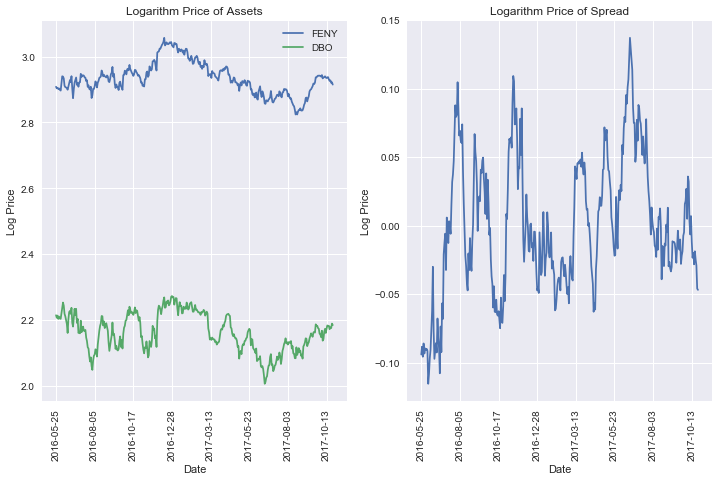

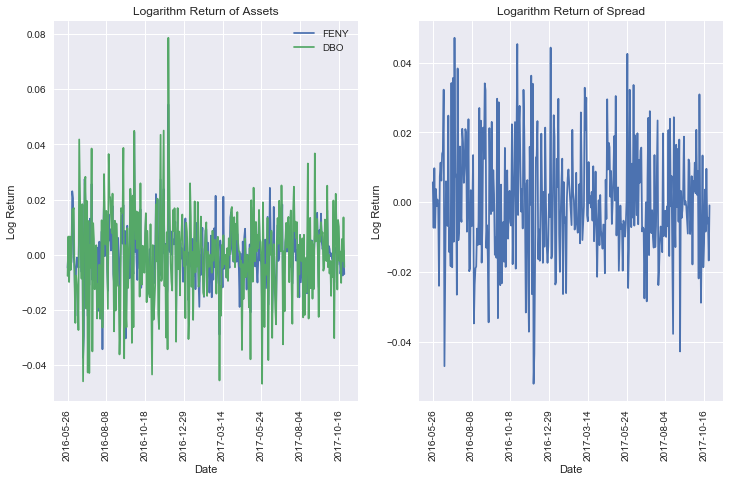

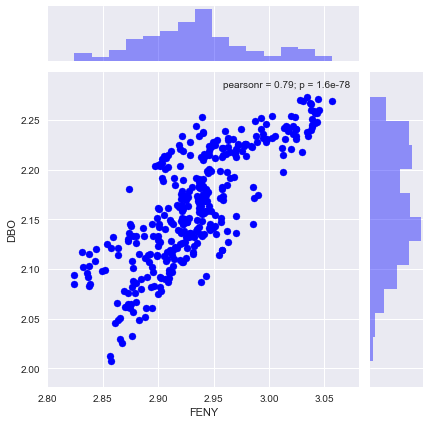

In [7]:
start_date, end_date = '2016-05-25', '2017-10-25'
h_r, spread, r_spread = pair_pres(['FENY', 'DBO'], start_date, end_date)

## STEP 2 Calculate Hurst Exponent and Half-life
The Hurst exponent is used as a measure of long-term memory of time series. It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases.
The Hurst exponent, H, is defined in terms of the asymptotic behaviour of the rescaled range as a function of the time span of a time series as follows
$$E\left[\frac{R(n)}{S(n)}\right]=Cn^H\ as\ n\rightarrow\infty$$
where $R(n)$ is the range of the first $n$ values and $S(n)$ is their standard deviation, $n$ is the time span of the observation (number of data points in a time series) and $C$ is a constant.

The goal of the Hurst Exponent is to provide us with a scalar value that will help us to identify (within the limits of statistical estimation) whether a series is mean reverting, random walking or trending.

The idea behind the Hurst Exponent calculation is that we can use the variance of a log price series to assess the rate of diffusive behaviour. For an arbitrary time lag $\tau$
, the variance is given by:
$$Var(\tau) = \langle|log(t+\tau)-log(t)|^2\rangle$$

Since we are comparing the rate of diffusion to that of a Geometric Brownian Motion, we can use the fact that at large $\tau$, we have that the variance is proportional to $\tau$ in the case of a GBM:
$$\langle|log(t+\tau)-log(t)|^2\rangle\sim\tau$$

The key insight is that if any autocorrelations exist (i.e. any sequential price movements possess non-zero correlation) then the above relationship is not valid. Instead, it can be modified to include an exponent value "$2H$
", which gives us the Hurst Exponent value $H$:
$$\langle|log(t+\tau)-log(t)|^2\rangle\sim\tau^{2H}$$

A time series can be characterised in the following manner with regard to the Hurst exponent (H):
1. H < 0.5: The time series is mean reverting
2. H = 0.5: The time series is a Geometric Brownian Motion
3. H > 0.5: The time series is trending

Reference https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing
          https://en.wikipedia.org/wiki/Hurst_exponent#Rescaled_range_.28R.2FS.29_analysis

In [104]:
def Hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [105]:
print('Hurst Exponent = %f' % Hurst(spread))

Hurst Exponent = 0.270621


The Hurst Exponent is under the 0.5 value of a random walk and we can therefore conclude that the series is mean reverting, which backs up our conclusion based on the Augmented Dickey Fuller test previously. This means that the spread series looks like a definite candidate for a mean reversion strategy, what with the spread series being mean reverting and all.

However just because a time series displays mean reverting properties, it doesn’t necessarily mean that we can trade it profitably – there’s a difference between a series that deviates and mean reverts every week and one that takes 10 years to mean revert. 

To get an idea of how long each mean reversion is going to take, we can look into the “half-life” of the time series. Please click here for more info on half-life.

In [106]:
def half_life(spread):
    
    #Run OLS regression on spread series and lagged version of itself
    spread_lag = spread.shift(1)
    spread_lag[0] = spread_lag[1]
    spread_ret = spread - spread_lag
    spread_ret[0] = spread_ret[1]
    spread_lag2 = st.add_constant(spread_lag)

    regr = OLS(spread_ret,spread_lag2).fit()
    halflife = round(-np.log(2) / regr.params[1],0)
 
    print('Halflife = %f' % halflife)

In [107]:
half_life(spread)

Halflife = 16.000000


## STEP 3 Model Spread as ARIMA

1. ACF/PACF plots of spread
2. Select number of lags by AIC criterion
3. Build ARIMA model and estimate mean and variance
4. Diagnose with residuals

In [8]:
def autocovar_plots(ts):
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(211)
    ax1.set_xlabel('lag')
    ax1.set_ylabel('ACF')
    fig = plot_acf(ts, ax = ax1, lags = 100, title = 'ACF of Series')
    ax2 = fig.add_subplot(212)
    ax2.set_xlabel('lag')
    ax2.set_ylabel('PACF')
    fig = plot_pacf(ts, ax = ax2, lags = 100, title = 'PACF of Series')
    plt.savefig('acf_pacf.png')

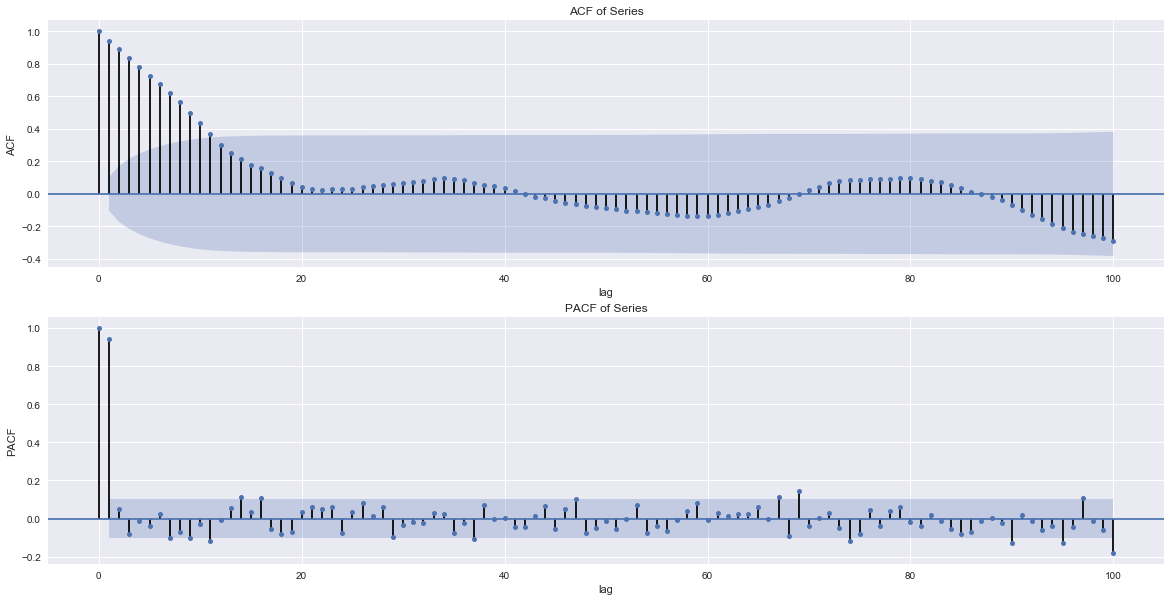

In [32]:
autocovar_plots(spread)

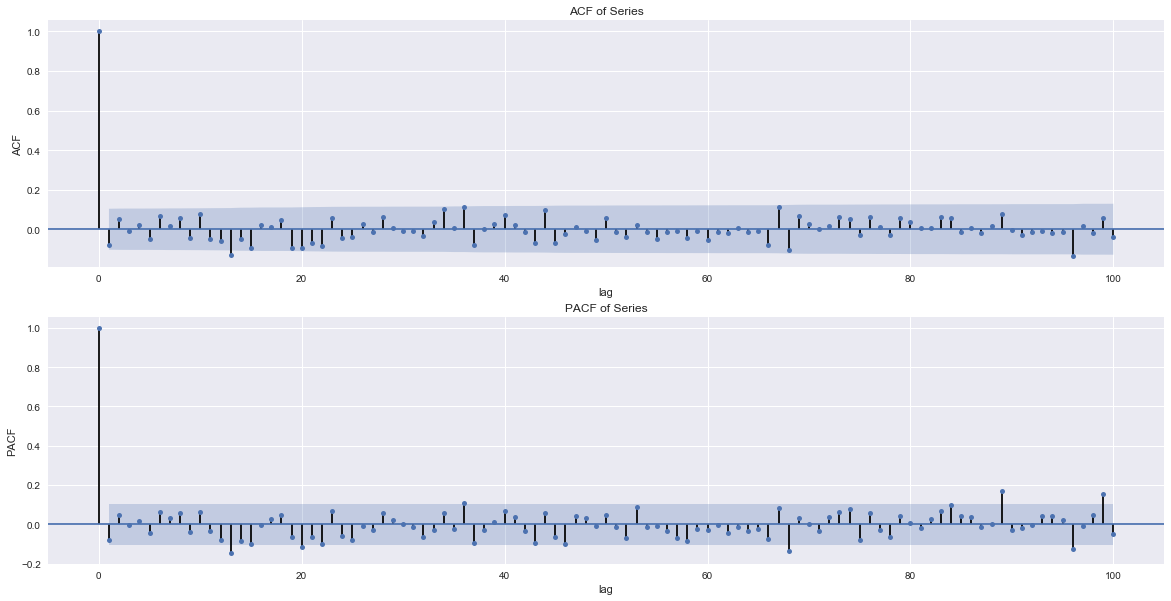

In [178]:
autocovar_plots(r_spread)

In [195]:
order_select = arma_order_select_ic(r_spread, max_ar = 3, max_ma = 3, ic = ['aic', 'bic'])
print('AIC order: %s' % (order_select.aic_min_order,))
print('BIC order: %s' % (order_select.bic_min_order,))

/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsm

AIC order: (2, 2)
BIC order: (0, 0)


In [9]:
arima1 = ARIMA(spread, order = (0,1,0)).fit(method = 'css')
print(arima1.summary2())
print('The squared error = %f' % np.square(arima1.resid).sum())

                           Results: ARIMA
Model:              ARIMA            BIC:                 -1903.8005
Dependent Variable: D.y              Log-Likelihood:      957.78    
Date:               2017-12-11 18:48 Scale:               1.0000    
No. Observations:   358              Method:              css       
Df Model:           1                Sample:              1         
Df Residuals:       357                                   9         
Converged:          1.0000           S.D. of innovations: 0.017     
No. Iterations:     1.0000           HQIC:                -1908.475 
AIC:                -1911.5615                                      
-----------------------------------------------------------------------
            Coef.     Std.Err.      t       P>|t|      [0.025    0.975]
-----------------------------------------------------------------------
const       0.0001      0.0009    0.1497    0.8811    -0.0016    0.0019

The squared error = 0.099453


/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


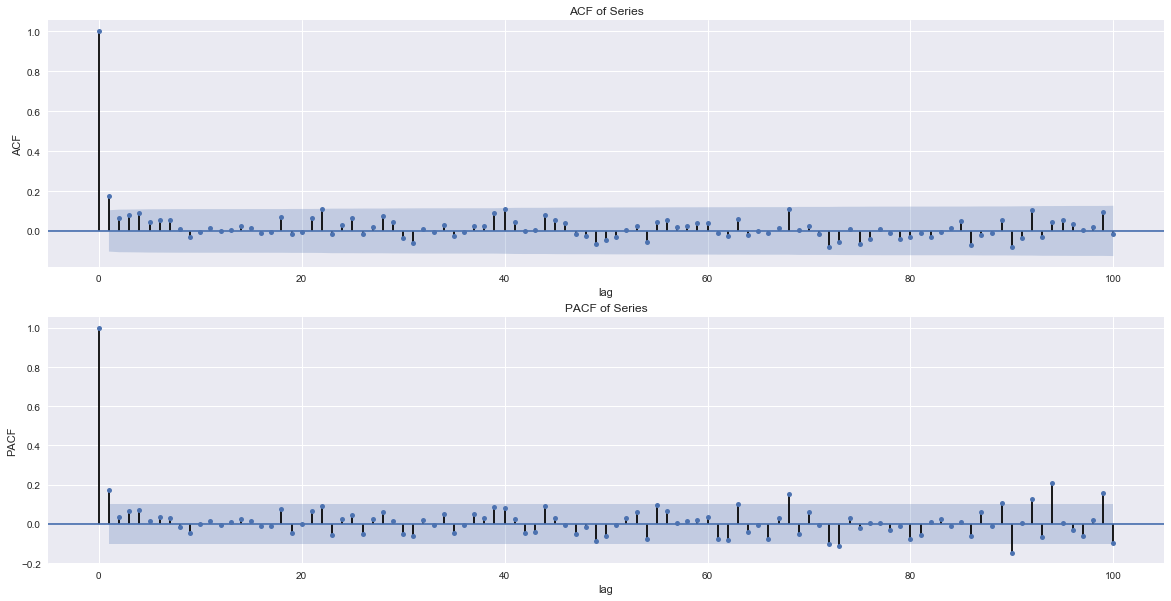

In [10]:
autocovar_plots(np.square(arima1.resid))

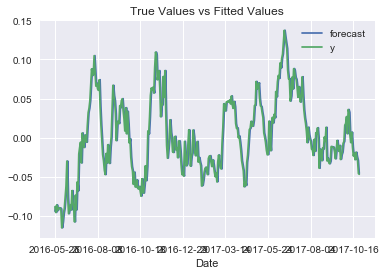

In [215]:
arima1.plot_predict()
plt.title('True Values vs Fitted Values')

In [216]:
arima2 = ARIMA(spread, order = (2,1,2)).fit(method = 'css')
print(arima2.summary2())
print('The squared error = %f' % np.square(arima2.resid).sum())

                           Results: ARIMA
Model:              ARIMA            BIC:                 -1878.6123
Dependent Variable: D.y              Log-Likelihood:      956.93    
Date:               2017-12-04 17:53 Scale:               1.0000    
No. Observations:   358              Method:              css       
Df Model:           5                Sample:              3         
Df Residuals:       351                                   9         
Converged:          1.0000           S.D. of innovations: 0.016     
No. Iterations:     57.0000          HQIC:                -1892.614 
AIC:                -1901.8619                                      
----------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const        0.0002     0.0003     0.6044   0.5460   -0.0004    0.0008
ar.L1.D.y   -0.0260     0.0300    -0.8672   0.3864   

/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


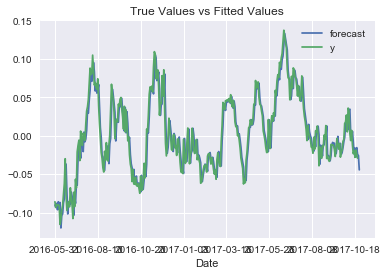

In [217]:
arima2.plot_predict()
plt.title('True Values vs Fitted Values')

### Diagnostics of Residuals
#### 1. Ljung-box test for no autocorrelation 

Null hypothesis: no autocorrelation
Ljung-box is a test on the cumulative sum of autocorrelations, so it's different from just looking at individual autocorrelation in the plots.

We reject the null of no autocorrelation if the p-value is small.

#### 2. Normality test

In [490]:
def diagnostic(resid, plot = True):   
    stats, p_value = acorr_ljungbox(resid)
    
    if plot:
        if resid.values.shape != (len(resid), ):
            resid = resid.values.reshape((len(resid),))
        fig = plt.figure(figsize=(16,4))
        ax = fig.add_subplot(131)
        ax.plot(resid)
        plt.title('Residuals')
    
        ax1 = fig.add_subplot(132)  
        ax1.plot(p_value)
        ax1.set_xlabel('lag')
        ax1.set_ylabel('p-value')
        plt.title('P-values of  Ljung-Box Test')
    
        ax2 = fig.add_subplot(133)
        qqplot(resid, ax = ax2, line = 's')
        plt.title('Normal Q-Q Plot of Residuals')
        
    return p_value

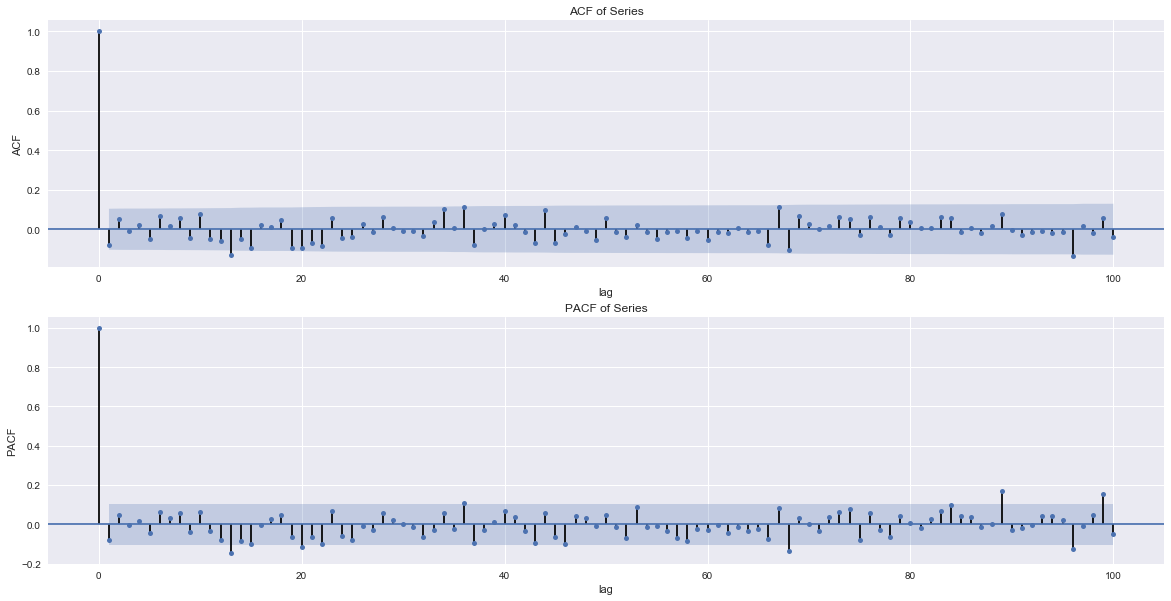

In [229]:
autocovar_plots(arima1.resid)

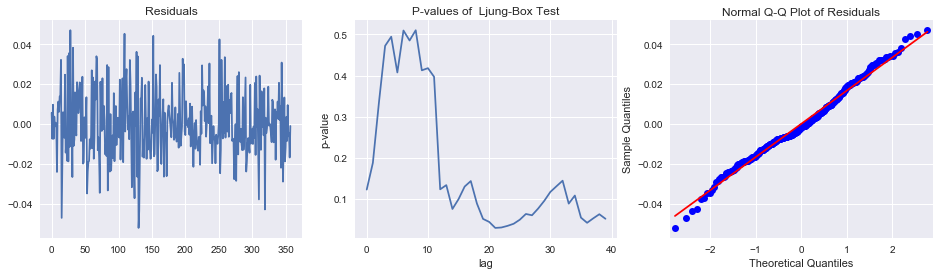

In [230]:
Lj_p = diagnostic(arima1.resid)

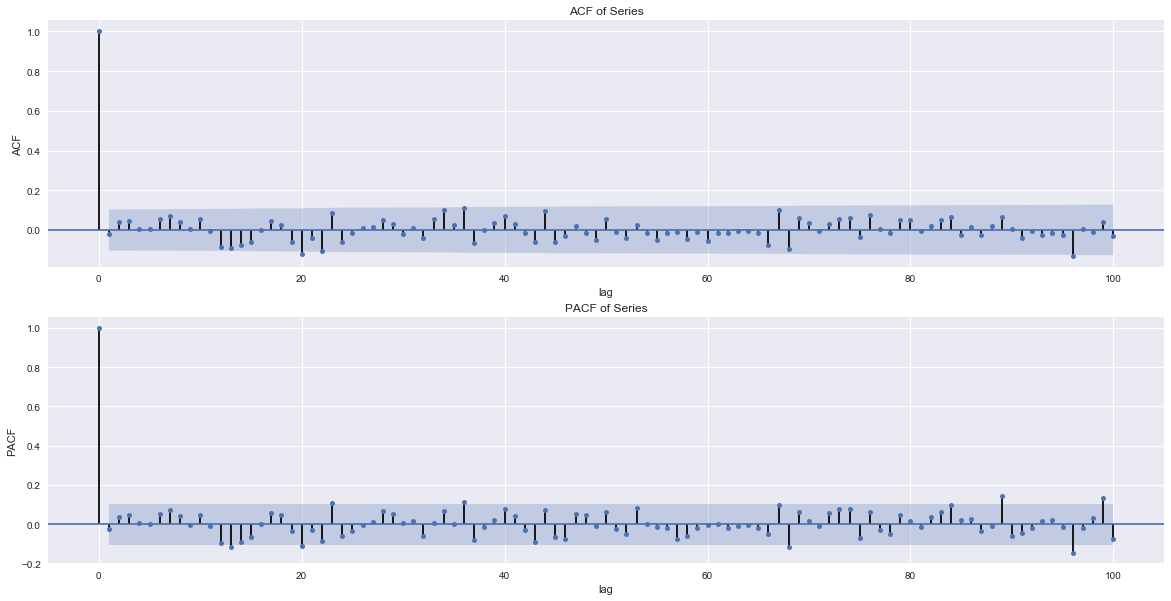

In [425]:
autocovar_plots(arima2.resid)
plt.savefig('aiama2_resid1.png')

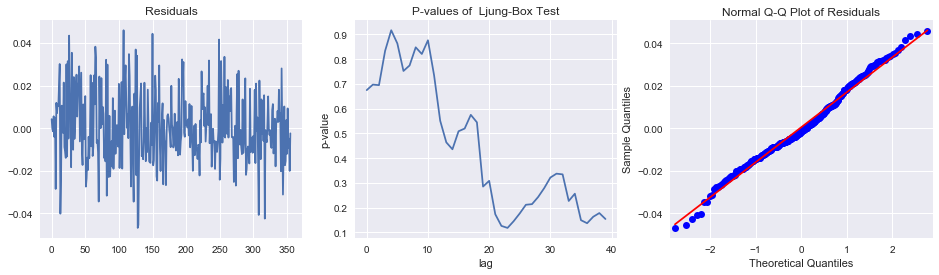

In [424]:
diagnostic(arima2.resid)
plt.savefig('arima2_resid2.png')

In [254]:
arima2.forecast(steps = 1)

(array([-0.04335029]),
 array([ 0.01645795]),
 array([[-0.07560727, -0.0110933 ]]))

In [259]:
def arima_model(ts):
    diff = (ts - ts.shift()).dropna()
    order_select = arma_order_select_ic(diff, max_ar = 4, max_ma = 4, ic = ['aic', 'bic'])
    
    try:
        p_a, q_a = order_select.aic_min_order
        result1 = ARIMA(ts, order = (p_a, 1, q_a)).fit(method = 'css')
    except ValueError:
        p_b, q_b = order_select.bic_min_order
        result1 = ARIMA(ts, order = (p_b, 1, q_b)).fit(method = 'css')
    
    Lj_pv1 = diagnostic(result1.resid, plot = False)
    
    p_b, q_b = order_select.bic_min_order
    result2 = ARIMA(ts, order = (p_b, 1, q_b)).fit(method = 'css')
    Lj_pv2 = diagnostic(result2.resid, plot = False)
    
    if (Lj_p < 0.1).sum() <= (Lj_p < 0.1).sum():
        result = result1
    else:
        result = resutl2
        
    pred_value, stderr, pred_ci = result.forecast(steps = 1)
    return np.sqrt(result.sigma2), pred_value.item(), stderr.item(), pred_ci[0]

In [260]:
arima_model(spread)

/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsm

(0.016457947279441252,
 -0.04335028512063398,
 0.016457947279441252,
 array([-0.07560727, -0.0110933 ]))

Trading Process

In [349]:
def PairsTrading_ARIMA(pair, test_start, test_end):
    
    data_test = pair_price_data(pair, test_start, test_end)
    train_ends = data_test.index.values.tolist()
    train_starts = [datetime.strftime(datetime.strptime(te, '%Y-%m-%d') + relativedelta(months = -17), '%Y-%m-%d') for te in train_ends]
    
    def Main(pair, start, end): 
        asset1, asset2 = pair
        print('Trade date is %s' % end)
        print('Obtain price data') 
        df = pair_price_data(pair, start, end)
        df = np.log(df)
        print('Obtain hedge ratio and spread') 
        h_r, spread = regression(df[asset1], df[asset2]) 
        print('Check stationary of the spread')
        adf_stat = ADF(spread, 0.05, print_conclusion = True)
        print('Build model of the spread')
        sigma, pred_value, stderr, CI = arima_model(spread)
        ci_u, ci_l = CI
        
        # trading strategy
        if pred_value - spread[-1] > 0:
            sig = 1
        elif pred_value < 0:
            sig = -1
        else:
            sig = 0
            
        return h_r, adf_stat, sigma, pred_value, stderr, ci_u, ci_l, sig
    
    hedge_ratio = []
    sigmas = []
    adf_pvalue = []
    pred_values = []
    stderrs = []
    ci_u = []
    ci_l = []
    signal = []

    for ts, te in zip(train_starts, train_ends):
        h_r, a_p, sigma, p, stderr, u, l, sig = Main(pair, ts, te)
        hedge_ratio.append(h_r)
        adf_pvalue.append(a_p)
        sigmas.append(sigma)
        pred_values.append(p)
        stderrs.append(stderr)
        ci_u.append(u)
        ci_l.append(l)
        signal.append(sig)
     
    
    data_test['hedge ratio'] = hedge_ratio
    data_test['ADF p-value'] = adf_pvalue
    data_test['Sigma'] = sigmas
    data_test['predict'] = pred_values
    data_test['std_error'] = stderrs
    data_test['CI_upper'] = ci_u
    data_test['CI_lower'] = ci_l
    data_test['Signal'] = signal
    
        
    return data_test

In [322]:
df = PairsTrading_ARIMA(['FENY', 'DBO'], '2017-10-26', '2017-11-26')

Trade date is 2017-10-26
Obtain price data
Obtain hedge ratio and spread
The hedge ratio is 1.355693.
Check stationary of the spread
Augmented Dickey Fuller test statistic = -3.38574009972
Augmented Dickey Fuller p-value = 0.0114547031241
the time series is stationary.
Build model of the spread


/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsm

Trade date is 2017-10-27
Obtain price data
Obtain hedge ratio and spread
The hedge ratio is 1.355704.
Check stationary of the spread
Augmented Dickey Fuller test statistic = -3.33726751506
Augmented Dickey Fuller p-value = 0.0132926107391
the time series is stationary.
Build model of the spread
Trade date is 2017-10-30
Obtain price data
Obtain hedge ratio and spread
The hedge ratio is 1.355724.
Check stationary of the spread
Augmented Dickey Fuller test statistic = -3.27548399955
Augmented Dickey Fuller p-value = 0.0160105443606
the time series is stationary.
Build model of the spread
Trade date is 2017-10-31
Obtain price data
Obtain hedge ratio and spread
The hedge ratio is 1.355615.
Check stationary of the spread
Augmented Dickey Fuller test statistic = -3.25895775091
Augmented Dickey Fuller p-value = 0.0168157526318
the time series is stationary.
Build model of the spread
Trade date is 2017-11-01
Obtain price data
Obtain hedge ratio and spread
The hedge ratio is 1.355640.
Check stat

/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:511: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:511: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Trade date is 2017-11-08
Obtain price data
Obtain hedge ratio and spread
The hedge ratio is 1.355535.
Check stationary of the spread
Augmented Dickey Fuller test statistic = -3.24572042545
Augmented Dickey Fuller p-value = 0.0174861147261
the time series is stationary.
Build model of the spread
Trade date is 2017-11-09
Obtain price data
Obtain hedge ratio and spread
The hedge ratio is 1.355534.
Check stationary of the spread
Augmented Dickey Fuller test statistic = -3.17973318411
Augmented Dickey Fuller p-value = 0.0211881839352
the time series is stationary.
Build model of the spread
Trade date is 2017-11-10
Obtain price data
Obtain hedge ratio and spread
The hedge ratio is 1.355522.
Check stationary of the spread
Augmented Dickey Fuller test statistic = -3.09353734647
Augmented Dickey Fuller p-value = 0.0270351652385
the time series is stationary.
Build model of the spread
Trade date is 2017-11-13
Obtain price data
Obtain hedge ratio and spread
The hedge ratio is 1.355493.
Check stat

In [323]:
df

,FENY,DBO,hedge ratio,ADF p-value,Sigma,predict,std_error,CI_upper,CI_lower,Signal
Date,,,,,,,,,,
2017-10-26,18.500000,8.96,1.355693,0.011455,0.016373,-0.052583,0.016373,-0.084673,-0.020493,1
2017-10-27,18.570000,9.15,1.355704,0.013293,0.016442,-0.075101,0.016442,-0.107327,-0.042875,1
2017-10-30,18.660000,9.19,1.355724,0.016011,0.016304,-0.083234,0.016304,-0.115190,-0.051278,-1
2017-10-31,18.770000,9.24,1.355615,0.016816,0.016532,-0.078252,0.016532,-0.110654,-0.045851,1
2017-11-01,19.010000,9.22,1.355640,0.011407,0.016492,-0.069640,0.016492,-0.101964,-0.037316,-1
2017-11-02,18.950001,9.30,1.355655,0.014832,0.016562,-0.076636,0.016562,-0.109098,-0.044175,1
2017-11-03,19.030001,9.45,1.355641,0.019450,0.016607,-0.096703,0.016607,-0.129253,-0.064154,1
2017-11-06,19.480000,9.73,1.355604,0.000251,0.016665,-0.113274,0.016665,-0.145936,-0.080611,1
2017-11-07,19.440001,9.72,1.355567,0.027734,0.016683,-0.115749,0.016683,-0.148447,-0.083051,-1


In [324]:
df_post = np.log(pair_price_data(['FENY', 'DBO'], '2017-10-26', '2017-11-27'))
spread_post = df_post['FENY'] - df['hedge ratio'] * df_post['DBO']

In [492]:
df.to_excel('arima_result.xlsx')

## STEP 4 VECM
The increments can be expressed as a function of the dis-equilibirium and the lagged increments.

In [11]:
from statsmodels.tsa.vector_ar.vecm import *

In [12]:
start_date, end_date = '2016-05-25', '2017-10-25'
data = np.log(pair_price_data(['FENY', 'DBO'], start_date, end_date))

### Lag order selection

In [13]:
lag_order = select_order(data = data, maxlags = 4, deterministic = 'nc') # ci: intercept only appears inside the cointegration relation
lag_order.summary()

/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,-17.97*,-17.90*,1.574e-08*,-17.94*
1,-17.96,-17.85,1.592e-08,-17.91
2,-17.96,-17.80,1.589e-08,-17.90
3,-17.95,-17.75,1.603e-08,-17.87
4,-17.94,-17.70,1.622e-08,-17.84


We will choose a lag order of 1 in the following modeling. And the model can be written as
$$\Delta y_t = \beta_{11}\Delta y_{t-1} + \alpha_y(y_{t-1}-\beta x_{t-1})+\epsilon_{yt}$$
$$\Delta x_t = \beta_{12}\Delta x_{t-1} + \alpha_xy(y_{t-1}-\beta x_{t-1})+\epsilon_{xt}$$
and 
$$\left [
\begin{matrix}
\Delta y_t \\
\Delta x_t
\end{matrix}
\right ]=\left [
\begin{matrix}
\beta_{11} \\
\beta_{12}
\end{matrix}
\right ]\left [
\begin{matrix}
\Delta y_{t-1} \\
\Delta x_{t-1}
\end{matrix}
\right ]+\left [
\begin{matrix}
\alpha_y \\
\alpha_x
\end{matrix}
\right ][1-\beta] \left [
\begin{matrix}
\Delta y_{t-1} \\
\Delta x_{t-1}
\end{matrix}
\right ]+\left [
\begin{matrix}
\epsilon_{yt} \\
\epsilon_{xt}
\end{matrix}
\right ]$$ in matrix form. Where $\alpha_y$ and $\alpha_x$ are the speed of adjustment to equilibirium and defined how the mispricing shall be corrected. $\beta$ is the cointegrating coefficient. 

### Estimation

In [335]:
vecm_fit.sigma_u # estimate white noise covariance matrix

array([[ 0.00011756,  0.00013175],
       [ 0.00013175,  0.00027672]])

In [15]:
vecm_fit = VECM(data, deterministic="nc", k_ar_diff = lag_order.aic, coint_rank = 1).fit()
vecm_fit.summary()

/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0242,0.012,2.105,0.035,0.002,0.047
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0621,0.018,3.518,0.000,0.028,0.097
,coef,std err,z,P>|z|,[0.025,0.975]
beta.1,1.0000,0,0,0.000,1.000,1.000
beta.2,-1.3569,0.006,-211.311,0.000,-1.370,-1.344


In [16]:
resid_y = pd.DataFrame([vecm_fit.resid[i][0] for i in range(len(vecm_fit.resid))])
resid_x = pd.DataFrame([vecm_fit.resid[i][1] for i in range(len(vecm_fit.resid))])

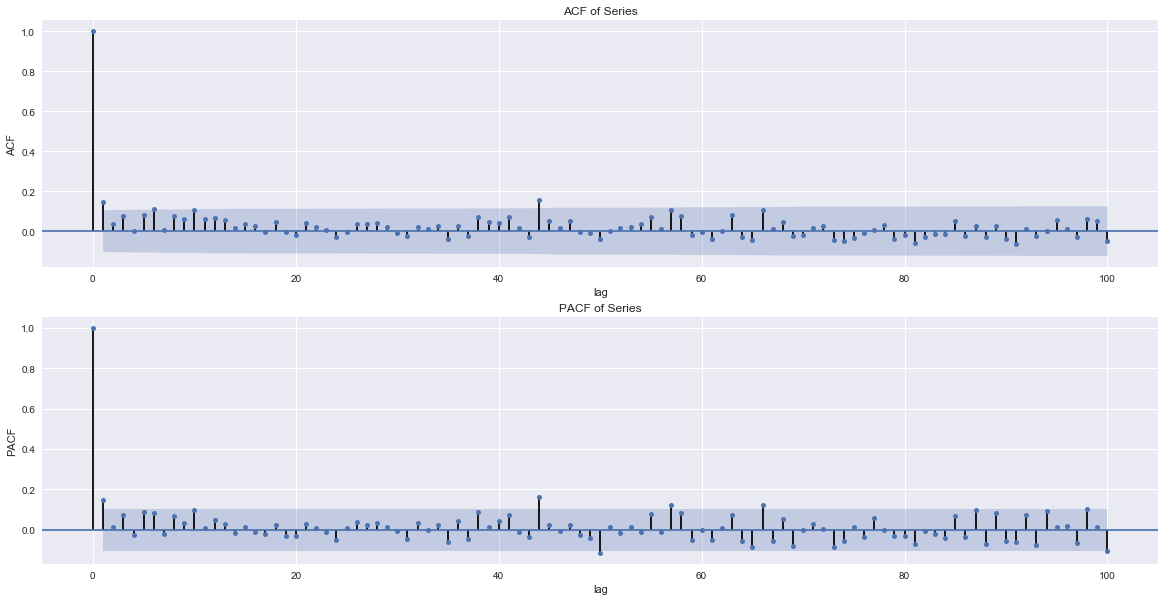

In [18]:
autocovar_plots(np.square(resid_x))

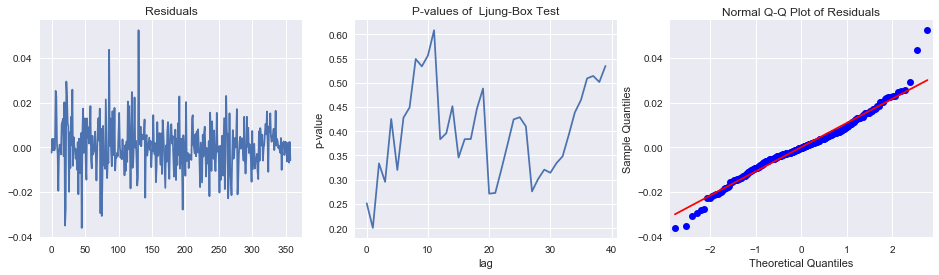

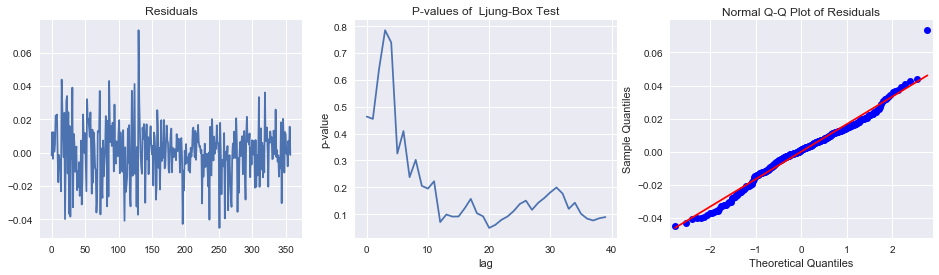

In [491]:
diagnostic(resid_y)
plt.savefig('resid_y.png')
diagnostic(resid_x)
plt.savefig('resid_x.png')

In [343]:
vecm_fit.test_normality().summary()

Test statistic,Critical value,p-value,df
88.81,9.488,0.000,4


In [441]:
vecm_fit.test_whiteness(nlags = 100)

In [344]:
vecm_fit.test_whiteness(nlags = 100).summary()

Test statistic,Critical value,p-value,df
328.5,445.5,0.995,398


In [447]:
def PairsTrading_VECM(pair, test_start, test_end):
    
    data_test = pair_price_data(pair, test_start, test_end)
    train_ends = data_test.index.values.tolist()
    train_starts = [datetime.strftime(datetime.strptime(te, '%Y-%m-%d') + relativedelta(months = -17), '%Y-%m-%d') for te in train_ends]
    
    def Main(pair, start, end):
        asset1, asset2 = pair
        print('Trade date is %s' % end)
        print('Obtain price data') 
        df = pair_price_data(pair, start, end)
        df = np.log(df)
        print('Build model of the two assets')
        lag_order = select_order(data = df, maxlags = 4, deterministic = 'nc')
        vecm_fit1 = VECM(df, deterministic="nc", k_ar_diff = lag_order.aic, coint_rank = 1).fit()
        vecm_fit2 = VECM(df, deterministic="nc", k_ar_diff = lag_order.bic, coint_rank = 1).fit()
        p1 = vecm_fit1.test_whiteness(nlags = 100).pvalue
        p2 = vecm_fit2.test_whiteness(nlags = 100).pvalue
        if p1 >= p2:
            vecm_fit = vecm_fit1
        else:
            vecm_fit = vecm_fit2
        s, lower, upper = vecm_fit.predict(steps = 1, alpha = 0.05)
        y, x = s[0]
        y_l, x_l = lower[0]
        y_u, x_u = upper[0]
        pred_s = y + vecm_fit.beta[1].item()*x
        ci_l = (y_l + vecm_fit.beta[1].item()*x_l)
        ci_u = (y_u + vecm_fit.beta[1].item()*x_u)
        # trading strategy
        t_s = df[asset1].values[-1] + vecm_fit.beta[1]*df[asset2].values[-1]
        if pred_s - t_s > 0:
            sig = 1
        elif pred_s - t_s < 0:
            sig = -1
        else:
            sig = 0
        return vecm_fit.beta[1].item(), t_s.item(), pred_s, ci_l, ci_u, sig
    
    hedge_ratio = []
    true_spread = []
    pred_values = []
    ci_u = []
    ci_l = []
    signal = []

    for ts, te in zip(train_starts, train_ends):
        h_r, t_s, p_s, l, u, sig = Main(pair, ts, te)
        hedge_ratio.append(-h_r)
        true_spread.append(t_s)
        pred_values.append(p_s)
        ci_u.append(u)
        ci_l.append(l)
        signal.append(sig)
     
    
    data_test['hedge ratio'] = hedge_ratio
    data_test['true spread'] = true_spread
    data_test['predict'] = pred_values
    data_test['CI_upper'] = ci_u
    data_test['CI_lower'] = ci_l
    data_test['Signal'] = signal
   
    return data_test

In [448]:
df2 = PairsTrading_VECM(['FENY', 'DBO'], '2017-10-26', '2017-11-26')

Trade date is 2017-10-26
Obtain price data
Build model of the two assets
Trade date is 2017-10-27
Obtain price data
Build model of the two assets
Trade date is 2017-10-30
Obtain price data
Build model of the two assets
Trade date is 2017-10-31
Obtain price data
Build model of the two assets
Trade date is 2017-11-01

/Users/Rachel/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Obtain price data
Build model of the two assets
Trade date is 2017-11-02
Obtain price data
Build model of the two assets
Trade date is 2017-11-03
Obtain price data
Build model of the two assets
Trade date is 2017-11-06
Obtain price data
Build model of the two assets
Trade date is 2017-11-07
Obtain price data
Build model of the two assets
Trade date is 2017-11-08
Obtain price data
Build model of the two assets
Trade date is 2017-11-09
Obtain price data
Build model of the two assets
Trade date is 2017-11-10
Obtain price data
Build model of the two assets
Trade date is 2017-11-13
Obtain price data
Build model of the two assets
Trade date is 2017-11-14
Obtain price data
Build model of the two assets
Trade date is 2017-11-15
Obtain price data
Build model of the two assets
Trade date is 2017-11-16
Obtain price data
Build model of the two assets
Trade date is 2017-11-17
Obtain price data
Build model of the two assets
Trade date is 2017-11-20
Obtain price data
Build model of the two assets
Tr

In [449]:
df2

,FENY,DBO,hedge ratio,true spread,predict,CI_upper,CI_lower,Signal
Date,,,,,,,,
2017-10-26,18.500000,8.96,1.356701,-0.057163,-0.053764,-0.076770,-0.030758,1
2017-10-27,18.570000,9.15,1.356408,-0.081206,-0.076418,-0.099512,-0.053324,1
2017-10-30,18.660000,9.19,1.356160,-0.081739,-0.077001,-0.100091,-0.053911,1
2017-10-31,18.770000,9.24,1.355984,-0.082826,-0.078074,-0.101134,-0.055013,1
2017-11-01,19.010000,9.22,1.356390,-0.068085,-0.064023,-0.087018,-0.041028,1
2017-11-02,18.950001,9.30,1.356045,-0.082195,-0.077396,-0.100415,-0.054377,1
2017-11-03,19.030001,9.45,1.355676,-0.098851,-0.093224,-0.116314,-0.070134,1
2017-11-06,19.480000,9.73,1.355281,-0.114166,-0.107901,-0.131136,-0.084667,1
2017-11-07,19.440001,9.72,1.355434,-0.115175,-0.108882,-0.132155,-0.085609,1


In [493]:
df2.to_excel('vecm_result.xlsx')

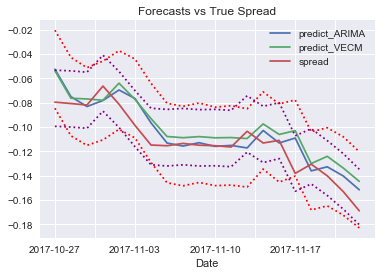

In [450]:
comp = pd.DataFrame({'spread':spread_post[1:], 'predict_ARIMA':df['predict'].values[:-1], 'predict_VECM':df2['predict'].shift().dropna()})
ax = comp.plot(title = 'Forecasts vs True Spread')
ax.plot(df['CI_upper'].values[:-1], linestyle = ':', color = 'r') # arima CI
ax.plot(df['CI_lower'].values[:-1], linestyle = ':', color = 'r')
ax.plot(df2['CI_upper'].values[1:], linestyle = ':', color = 'purple') # vecm CI
ax.plot(df2['CI_lower'].values[1:], linestyle = ':', color = 'purple')
plt.savefig('arima_vecm.png')

PROBLEM
1. ADT test results changes with rolling historical window
To address this concern, consider rolling adf test.
https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=4&cad=rja&uact=8&ved=0ahUKEwjL9OzIreXXAhXKOSYKHT9VBYMQFgg7MAM&url=http%3A%2F%2Fink.library.smu.edu.sg%2Fcgi%2Fviewcontent.cgi%3Farticle%3D1027%26context%3Detd_coll&usg=AOvVaw1YYbc8QYBlFTcYdL_Monsy